In [4]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry as geom
import plotly.plotly as py
import sys
 

#added this because it's indicated as useful but not imported
import urllib
from zipfile import ZipFile
from io import BytesIO
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup as bs
import re

from matplotlib import animation, rc
from IPython.display import display, HTML

In [5]:
with open("keys.json") as json_file:    
    keys = json.load(json_file)
census_key = keys["census"]["api_key"]

In [6]:
census_vars = json.loads(urllib.request.urlopen("http://api.census.gov/data/2014/acs5/variables.json").read().decode('utf-8'))["variables"]
income_brackets = dict([(key, value["label"]) for key, value in census_vars.items() if "B19001_" in key and key[-1] == "E"])

In [7]:
from us import states
from census import Census

def getincome20xx(income_brackets, years, census_key, zips):
    c = Census(census_key)
    df = pd.DataFrame()
    for year in years:
        tempget = c.acs5.zipcode((tuple([key[0] for key in income_brackets.items()])), Census.ALL, year=year)
        tempDF = pd.DataFrame(tempget)
        tempDF.columns = [income_brackets[tempDF.columns[i]] if i < len(income_brackets) else tempDF.columns[i] for i in range(len(tempDF.columns))]
        tempDF = tempDF[tempDF[tempDF.columns[-1]].isin(zips)]
        tempDF["year"] = year
        df = df.append(tempDF)
    return df

I forgot I wrote this. dope. :D

In [8]:
zipgeojson = "https://github.com/YuHuaCheng/Map/raw/master/data/nyc-zip-code-tabulation-areas-polygons.geojson"

# save the NYC map data under "data" folder
zipsfile = os.path.join("data",zipgeojson.split("/")[-1])

# read the saved NYC map data file
try:
    NY = gpd.read_file(zipsfile) # NYC map data with Zipcode
except OSError as e:
    urllib.request.urlretrieve(zipgeojson, zipsfile)
    
    #zips geojson had a var assignment that caused problems
    fin      = open(zipsfile)
    
    lines    = [line for line in fin]
    lines[0] = lines[0].replace("var nycdata = ", "")
    
    fin.close()
    
    fout = open(zipsfile, "w")
    for line in lines:
        fout.write(line)
    fout.flush()
    fout.close()
    
    NY = gpd.read_file(zipsfile)
    
NY.shape # NYC is composed of 262 subarea on the map data

(262, 12)

In [9]:
QN = NY[NY.borough == "Queens"]
zips_QN = QN.postalCode.unique()

In [10]:
theDF = getincome20xx(income_brackets,range(2011,2015), census_key, zips_QN)

In [11]:
newcols = ["total", "0", "10", "15", "20", "25", "30", "35", "40", "45", "50", "60", "75", "100", "125", "150", "200", "ZIP", "year"]
theDF.columns = newcols
theDF[newcols] = theDF[newcols].apply(pd.to_numeric)
theDF.head()

,total,0,10,15,20,25,30,35,40,45,50,60,75,100,125,150,200,ZIP,year
2673,9059,244,161,156,331,232,177,397,230,247,456,765,1135,1086,916,1464,1062,11001,2011
2675,5131,149,221,163,130,252,271,165,109,199,391,400,777,570,614,476,244,11004,2011
2676,1356,22,42,85,76,74,54,34,68,39,145,89,247,163,46,31,141,11005,2011
2683,13438,230,313,281,509,499,219,455,380,344,687,1172,1874,1526,1426,1822,1701,11040,2011
2686,2530,156,155,170,100,94,87,133,159,81,237,192,341,186,203,170,66,11096,2011


In [12]:
theDF.to_csv(os.path.join('data', "QN_incomeDF.csv"))

In [13]:
QN_files = ["https://www.huduser.gov/portal/datasets/fmr/fmr2010f/FY2010_4050_Final_PostRDDs.xls",
         "https://www.huduser.gov/portal/datasets/fmr/fmr2011f/fy2011_equiv_zc_rents_acs.xls",
         "https://www.huduser.gov/portal/datasets/fmr/fmr2012f/small_area_fmrs_fy2012.xls",
         "https://www.huduser.gov/portal/datasets/fmr/fmr2013p/small_area_fmrs_fy2013.xls",
         "https://www.huduser.gov/portal/datasets/fmr/fmr2014f/small_area_fmrs_fy2014.xls"]

In [14]:
from JP_Cache import get_cached_or_dl
from IPython.display import display

In [15]:
rent_per_year = get_cached_or_dl(QN_files)

In [16]:
for i in range(len(rent_per_year)):
    for j in rent_per_year[i].columns.values:
        if j == 'zip' or j == 'ZIP':
            rent_per_year[i].rename(columns={j: 'ZIP' }, inplace=True)
        if j == 'countyname' or j == 'County Name' or j == 'County_Name':
            rent_per_year[i].rename(columns={j: 'CountyName' }, inplace=True)
        if j == 'State Name' or j == 'state_alpha':
            rent_per_year[i].rename(columns={j: 'StateName' }, inplace=True)
        if j == 'area_rent_br0' or j == 'fmr0':
            rent_per_year[i].rename(columns={j: 'rent0' }, inplace=True)
        if j == 'area_rent_br1' or j == 'fmr1':
            rent_per_year[i].rename(columns={j: 'rent1' }, inplace=True)
        if j == 'area_rent_br2' or j == 'fmr2':
            rent_per_year[i].rename(columns={j: 'rent2' }, inplace=True)
        if j == 'area_rent_br3' or j == 'fmr3':
            rent_per_year[i].rename(columns={j: 'rent3' }, inplace=True)
        if j == 'area_rent_br4' or j == 'fmr4':
            rent_per_year[i].rename(columns={j: 'rent4' }, inplace=True)
        if j == 'state':
            rent_per_year[i].rename(columns={j: 'State' }, inplace=True)

In [17]:
#df_14 = 
#df_14 = df_14[['StateName','CountyName','rent0','rent1','rent2','rent3','rent4','ZIP']]
#df_14.head()

In [18]:
rent_per_year[1]["year"] = 2011
rent_per_year[2]["year"] = 2012
rent_per_year[3]["year"] = 2013
rent_per_year[4]["year"] = 2014
rent_per_year = rent_per_year[1:] # drop 2010

In [19]:
rent_per_year_QN = []
for rentdf in rent_per_year:
    #display(rentdf.head())
    rent_per_year_QN.append(rentdf[(rentdf.CountyName == 'Queens County') & (rentdf.State == 36)])

In [20]:
rent_per_year_QN[0]["StateName"] = "New York"

//anaconda/envs/DataScience-Project/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [21]:
for rentdf in rent_per_year_QN:
    display(rentdf.head())

,cbsamet,State,county,ZIP,CountyName,CBSA_Name,rent0,rent1,rent2,rent3,rent4,year,StateName
12825,35620,36,81,11001,Queens County,"New York-Northern New Jersey-Long Island, NY-N...",1300,1390,1570,1950,2150,2011,New York
12826,35620,36,81,11004,Queens County,"New York-Northern New Jersey-Long Island, NY-N...",1130,1200,1360,1690,1870,2011,New York
12827,35620,36,81,11005,Queens County,"New York-Northern New Jersey-Long Island, NY-N...",1180,1260,1420,1760,1950,2011,New York
12828,35620,36,81,11040,Queens County,"New York-Northern New Jersey-Long Island, NY-N...",1440,1530,1730,2140,2370,2011,New York
12829,35620,36,81,11101,Queens County,"New York-Northern New Jersey-Long Island, NY-N...",1120,1190,1350,1670,1850,2011,New York


,State,StateName,County,CountyName,CBSA,CBSA Name,ZIP,rent0,rent1,rent2,rent3,rent4,year
14332,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11001,1280,1400,1600,2020,2440,2012
14333,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11003,1330,1450,1660,2090,2530,2012
14334,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11004,1100,1210,1380,1740,2110,2012
14335,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11005,1560,1710,1950,2460,2980,2012
14336,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11020,1250,1370,1560,1970,2380,2012


,State,StateName,County,CountyName,CBSA,CBSA Name,ZIP,rent0,rent1,rent2,rent3,rent4,year
14844,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11001,1260,1320,1560,2030,2390,2013
14845,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11004,1150,1200,1420,1850,2180,2013
14846,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11005,1370,1430,1690,2200,2590,2013
14847,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11040,1330,1390,1650,2150,2530,2013
14848,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11101,1090,1140,1350,1760,2070,2013


,State,StateName,County,CountyName,CBSA,CBSA Name,ZIP,rent0,rent1,rent2,rent3,rent4,year
14880,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11001,1250,1310,1550,2020,2380,2014
14881,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11004,1140,1190,1410,1830,2160,2014
14882,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11005,1360,1420,1680,2190,2570,2014
14883,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11040,1320,1380,1640,2130,2510,2014
14884,36,New York,81,Queens County,35620,"New York-Northern New Jersey-Long Island, NY-N...",11101,1080,1130,1340,1740,2050,2014


In [22]:
rentQN = pd.DataFrame()
for rentdf in rent_per_year_QN:
    tempdf = rentdf[['State','CountyName','rent0','rent1','rent2','rent3','rent4','ZIP', 'year']]
    print((len(rentdf), len(tempdf)))
    rentQN = rentQN.append(tempdf, ignore_index=True)
print(len(rentQN))
rentQN.head()

(64, 64)
(73, 73)
(68, 68)
(69, 69)
274


,State,CountyName,rent0,rent1,rent2,rent3,rent4,ZIP,year
0,36,Queens County,1300,1390,1570,1950,2150,11001,2011
1,36,Queens County,1130,1200,1360,1690,1870,11004,2011
2,36,Queens County,1180,1260,1420,1760,1950,11005,2011
3,36,Queens County,1440,1530,1730,2140,2370,11040,2011
4,36,Queens County,1120,1190,1350,1670,1850,11101,2011


In [23]:
rentQN[['rent0','rent1','rent2','rent3','rent4',"ZIP", "year"]] = rentQN[['rent0','rent1','rent2','rent3','rent4',"ZIP", "year"]].apply(pd.to_numeric)
rentQN.head()

,State,CountyName,rent0,rent1,rent2,rent3,rent4,ZIP,year
0,36,Queens County,1300,1390,1570,1950,2150,11001,2011
1,36,Queens County,1130,1200,1360,1690,1870,11004,2011
2,36,Queens County,1180,1260,1420,1760,1950,11005,2011
3,36,Queens County,1440,1530,1730,2140,2370,11040,2011
4,36,Queens County,1120,1190,1350,1670,1850,11101,2011


In [24]:
rentQN.to_csv(os.path.join('data', "QN_rentDF.csv"))

In [25]:
merged = pd.merge(theDF,rentQN,how = "inner", on =['year', 'ZIP'])
merged.head()

,total,0,10,15,20,25,30,35,40,45,...,200,ZIP,year,State,CountyName,rent0,rent1,rent2,rent3,rent4
0,9059,244,161,156,331,232,177,397,230,247,...,1062,11001,2011,36,Queens County,1300,1390,1570,1950,2150
1,5131,149,221,163,130,252,271,165,109,199,...,244,11004,2011,36,Queens County,1130,1200,1360,1690,1870
2,1356,22,42,85,76,74,54,34,68,39,...,141,11005,2011,36,Queens County,1180,1260,1420,1760,1950
3,13438,230,313,281,509,499,219,455,380,344,...,1701,11040,2011,36,Queens County,1440,1530,1730,2140,2370
4,9910,1306,732,481,740,601,513,392,431,382,...,303,11101,2011,36,Queens County,1120,1190,1350,1670,1850


In [26]:
merged.to_csv("data/QN_merged.csv")

In [27]:
theDF.head()

,total,0,10,15,20,25,30,35,40,45,50,60,75,100,125,150,200,ZIP,year
2673,9059,244,161,156,331,232,177,397,230,247,456,765,1135,1086,916,1464,1062,11001,2011
2675,5131,149,221,163,130,252,271,165,109,199,391,400,777,570,614,476,244,11004,2011
2676,1356,22,42,85,76,74,54,34,68,39,145,89,247,163,46,31,141,11005,2011
2683,13438,230,313,281,509,499,219,455,380,344,687,1172,1874,1526,1426,1822,1701,11040,2011
2686,2530,156,155,170,100,94,87,133,159,81,237,192,341,186,203,170,66,11096,2011


Tutorial: http://seaborn.pydata.org/tutorial.html

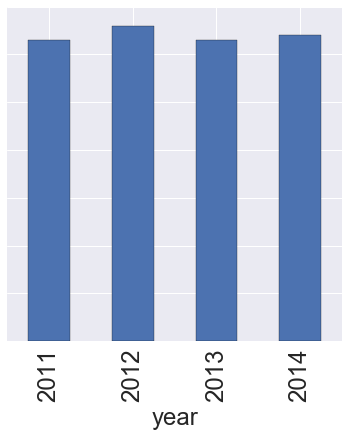

In [28]:

fd = merged.groupby("year").size().plot(kind="bar", figsize=(6, 6))

fd.set_yticklabels([])  # turn off y tick labels

# resize x label
xlabel = fd.xaxis.get_label()
xlabel.set_fontsize(24)

# resize x tick labels
lb = fd.xaxis.get_ticklabels()
[label.set_fontsize(24) for label in lb];

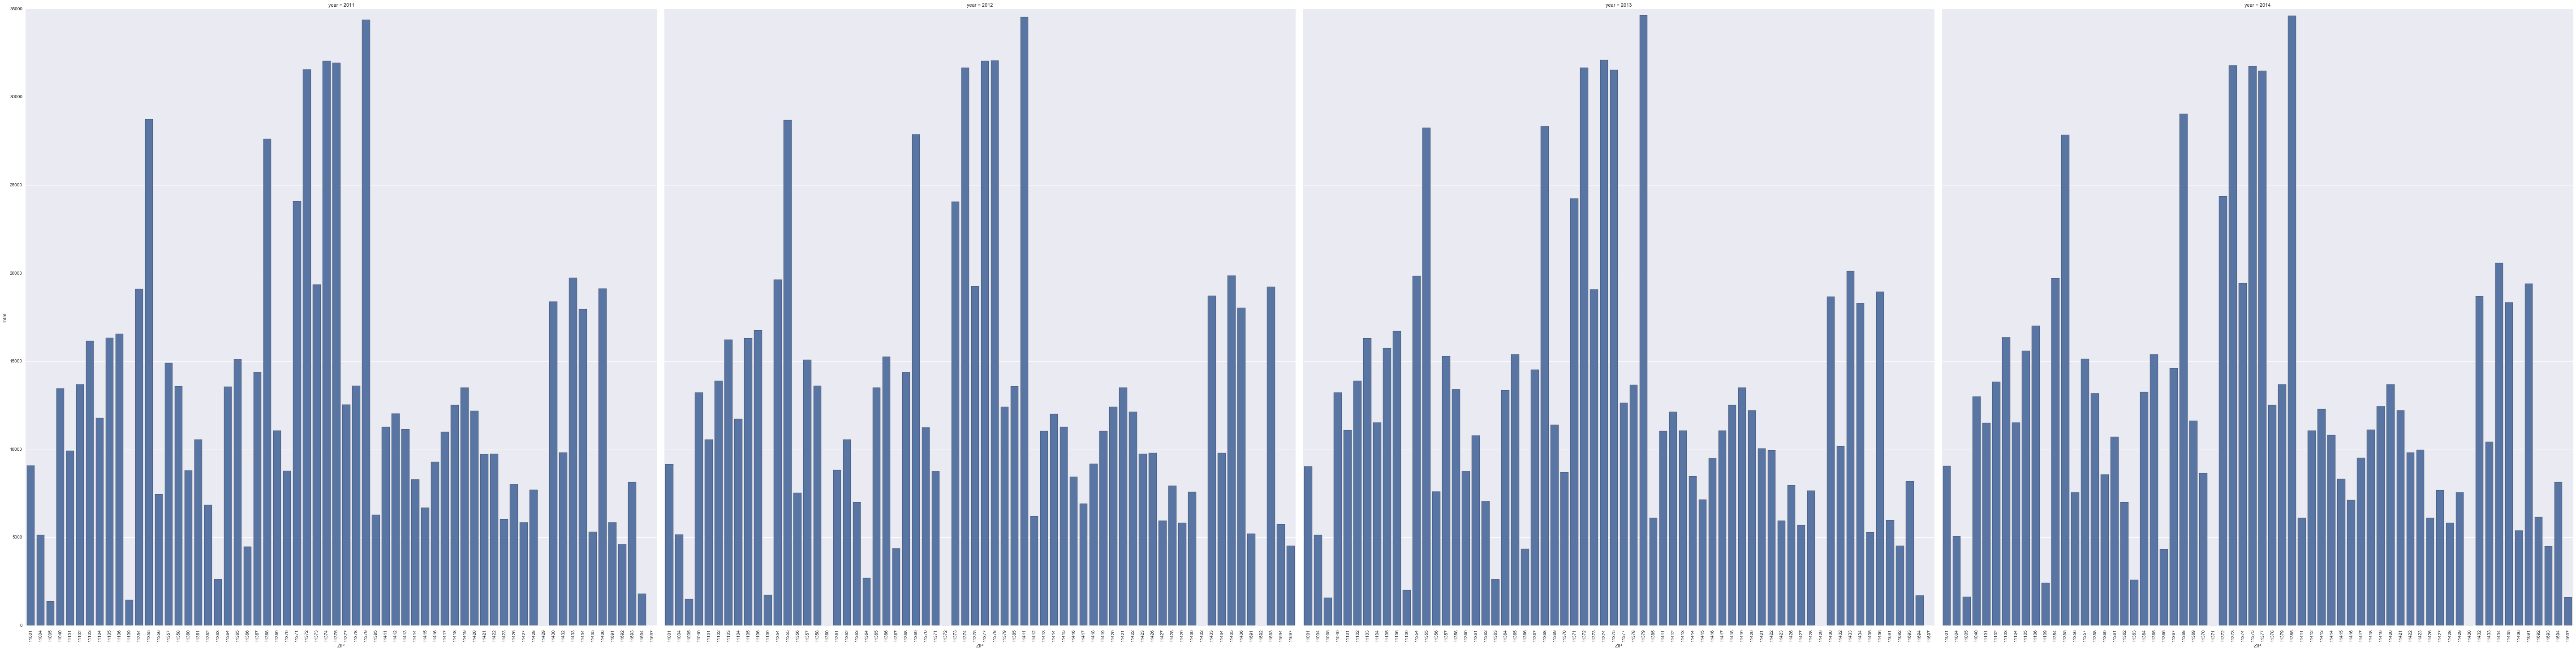

In [ ]:
g = sns.FacetGrid(merged, col="year", size=20, aspect=1)
g.map(sns.barplot, "ZIP", "total")
g.set_xticklabels(rotation=90)